# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services


**Sebastian Uribe**

December , 2019 

In this project, I am going to analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. The goal is to use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company.

Second part required desing a  a model that predicts which individuals are most likely to convert into becoming customers for the company. 

Arvato Bertelsman (Financial Solutions Division) is an international financial service provider
from Germany, they offer solutions related to ID & Fraud Managemet, Credit Risk Management,
Payment & Financing Services and Debt Collection Services. Like every company with a marketing
department, it is important to understand who their customers are, what are their characteristics,
how is their payment behavior and more, all important information to provide a good
service, but most importantly to keep profits up !.

For any company( not only Arvato ), designing efficient marketing campaign on how to acquire
new customers is not an easy task, it involves a series of multiple studies to understand
customers information and design strategic campaigns to maximize customer’s acquisition taking
into consideration the cost of the campaign. You can’t just send ads to any non-client with
publicity, too much money spend and with little ROI 1, its more effective to send ads to those who
shares similar characteristics to your already clients. The big and important questions is "what are
those characteristics that groups my clients based on their characteristics ?". Thankfully some Machine
learning methods we can answer it.

## Problem Statement
The goal of this project is to perform and analyze a customer segmentation that allows the principal
characteristics of the core business customers. This finding’s will be later be used as part of
information to predict which individuals are most likely to convert into new customers.
From Arvatos perspective, this project might help answering the following questions:

• How can the mail-order company acquire new clients more efficiently.
\
• Which people are most likely new customers ?

This kind of problem is both an unsupervised and supervised machine learning problem. For
the unsupervised part of the project, we are provided with features of demographic data from
population of Germany and customers of the mail-order company to apply any clustering technic
looking patterns to segment posible clients. There is not right anwser here, but the answer must be according to the financial needs of Arvato. For the supervised part, it is clearly a classification
problem, with a binary target that represents which individuals are most likely to be new
customers (Represented as 1) and those who are not very liekly (Represented as 0).

## Evaluation Metrics

**Supervised Stage** : 

Area Under the Receiver Operating Characteristic Curve [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) is a common metric used when predicting the probability  for binary classifiers, since this is the evaluation metric at the [Kaggle - Udacity challengue](https://www.kaggle.com/c/udacity-arvato-identify-customers/overview/evaluation), this will be the metric to evaluated the selected model.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# magic word for producing visualizations in notebook
%matplotlib inline

In [53]:
# Change pandas viewing options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10)

## Part 0: Get to Know the Data

There are four data files associated with this project:

data can be found in [Kaggle](https://www.kaggle.com/c/udacity-arvato-identify-customers/data)

- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.


## TARGET

In [3]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [4]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [5]:
mailout_train['RESPONSE'].value_counts(normalize=True)

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

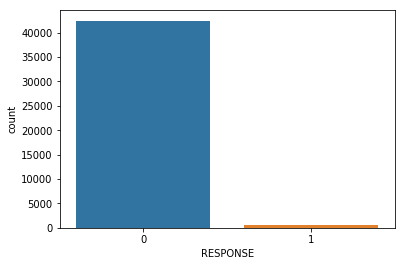

In [6]:
sns.countplot(x='RESPONSE',data=mailout_train);

Yep... It is a umbalanced problem !

## Features Missing

In [7]:
from utils import missing_values_table

In [8]:
mailout_train_missing=missing_values_table(mailout_train)

Dataframe has 367 columns. 
273 has missing values


In [9]:
mailout_train_missing.head(10)

,Missing,% of Total Values
ALTER_KIND4,42921,99.9
ALTER_KIND3,42788,99.6
ALTER_KIND2,42206,98.2
ALTER_KIND1,40974,95.4
KK_KUNDENTYP,25316,58.9
EXTSEL992,15948,37.1
W_KEIT_KIND_HH,9678,22.5
HH_DELTA_FLAG,9678,22.5
KBA05_ZUL1,8648,20.1
KBA05_KRSZUL,8648,20.1


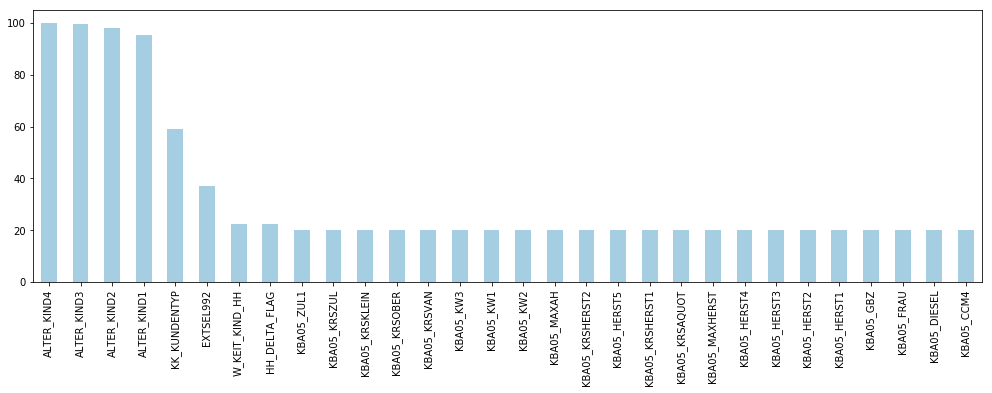

In [10]:
mailout_train_missing['% of Total Values'].head(30).plot(kind ='bar', figsize=(17,5),colormap='Paired')

Since there are some features that has 2 possible options when the value is unknown, I created the following function that will replace those value according to the dias_unknown.csv, first It will evaluated if a feature has 2 possible options when the value is unknown and will unified them for the first value that appears in the Value columns,  then it will replace missing values with **NaN**

In [11]:
def replace_NaN_data(dataframe):
    
    dias = pd.read_csv('files/dias_unknown.csv',sep=';')
    values_to_replace=dias.set_index('Attribute').to_dict()['Value']
    
    for col in dataframe.columns:
        if col in dias.Attribute.unique():
            if(len(values_to_replace[col].split(','))>1):
                dataframe.loc[dataframe[col]==int(values_to_replace[col].split(',')[1]), col] = int(values_to_replace[col].split(',')[0])
                dataframe.loc[dataframe[col]==int(values_to_replace[col].split(',')[0]), col] = np.nan
            else:
                dataframe.loc[dataframe[col]==int(values_to_replace[col]), col] = np.nan
    
    dataframe['CAMEO_INTL_2015']=dataframe['CAMEO_INTL_2015'].replace('XX',np.nan)
    dataframe['CAMEO_INTL_2015']=dataframe['CAMEO_INTL_2015'].astype('float')

    dataframe['CAMEO_DEUG_2015']=dataframe['CAMEO_DEUG_2015'].replace('X',np.nan)
    dataframe['CAMEO_DEUG_2015']=dataframe['CAMEO_DEUG_2015'].astype('float')
    
    dataframe['CAMEO_DEU_2015']=dataframe['CAMEO_DEU_2015'].replace('X',np.nan)
    dataframe['CAMEO_DEU_2015']=dataframe['CAMEO_DEU_2015'].replace('XX',np.nan)
    
            
    return dataframe

In [12]:
mailout_train = replace_NaN_data(mailout_train)

In [13]:
mailout_train_missing=missing_values_table(mailout_train)

Dataframe has 367 columns. 
334 has missing values


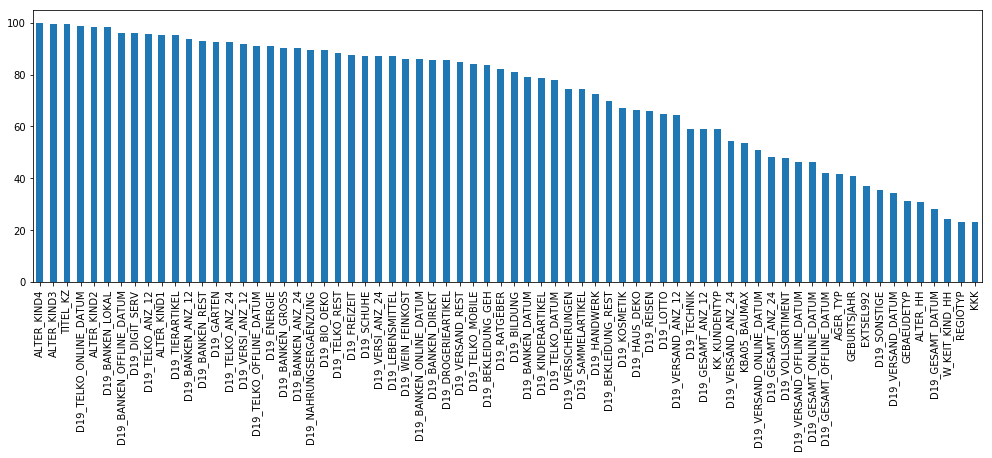

In [14]:
mailout_train_missing['% of Total Values'].head(70).plot(kind ='bar', figsize=(17,5))

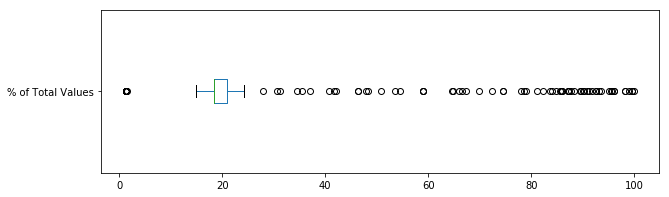

In [15]:
mailout_train_missing['% of Total Values'].plot(kind ='box', figsize=(10,3),vert=False)

Still there are features with a lot of missing values. I set a Threshold of 30 % since I could be leading to a duplicated to much information that it becomes noise.

In [16]:
missing_columns_to_drop=mailout_train_missing[mailout_train_missing['% of Total Values']>=30].index
missing_columns_to_drop

Index(['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'D19_TELKO_ONLINE_DATUM', 'ALTER_KIND2', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_DIGIT_SERV', 'D19_TELKO_ANZ_12', 'ALTER_KIND1', 'D19_TIERARTIKEL', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_REST', 'D19_GARTEN', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_TELKO_OFFLINE_DATUM', 'D19_ENERGIE', 'D19_BANKEN_GROSS', 'D19_BANKEN_ANZ_24', 'D19_NAHRUNGSERGAENZUNG', 'D19_BIO_OEKO', 'D19_TELKO_REST', 'D19_FREIZEIT', 'D19_SCHUHE', 'D19_VERSI_ANZ_24', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_DIREKT', 'D19_DROGERIEARTIKEL', 'D19_VERSAND_REST', 'D19_TELKO_MOBILE', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_BILDUNG', 'D19_BANKEN_DATUM', 'D19_KINDERARTIKEL', 'D19_TELKO_DATUM', 'D19_VERSICHERUNGEN', 'D19_SAMMELARTIKEL', 'D19_HANDWERK', 'D19_BEKLEIDUNG_REST', 'D19_KOSMETIK', 'D19_HAUS_DEKO', 'D19_REISEN', 'D19_LOTTO', 'D19_VERSAND_ANZ_12', 'D19_TECHNIK', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP', 'D19_VERSAND_ANZ_24',


In [17]:
mailout_train.drop(missing_columns_to_drop,axis=1,inplace=True)

In [18]:
azdias_missing_2=missing_values_table(mailout_train)

Dataframe has 301 columns. 
268 has missing values


## Rows with Missing data

Lets Check percentage of missing values pair row

In [19]:
clients_missing_data=(mailout_train.isnull().sum(axis=1)*100)/mailout_train.shape[1]

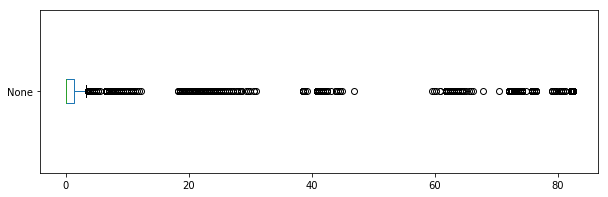

In [20]:
clients_missing_data.plot(kind='box', figsize=(10,3),vert=False);

There are a lot of clients that are missing a lot of information, those clients might be not worth saving, since the final output will be a client with almost every feature fill with the mean, median or mode of the corresponding feature.

In [21]:
sum(clients_missing_data>25)

7999

In [22]:
mailout_train.shape

(42962, 301)

In [23]:
mailout_train.dropna(thresh=200,inplace=True)

In [24]:
mailout_train.shape

(35000, 301)

## Cleaning and Preprocessing

An strategy to deal with the rest of features with **NaN**  will be imputation with median or most frequent value. Statistcally this doesnt affect the feautre distribution. This is way much butter than dropping points as also it gives more accurate results than dropping data points or columns entirely.

 * Numerical data will be imputed with median value in the column to deal with outliers.
 
 * Categorial data will be imputed with  the most frequent value. 

 I create a file name *data_types.csv* manually, checking each feature with the DIALES Files to determine if a columns was numeric, categorical , or datetime. I add a column to express if the categorical feature can be represented in an ordinal way or needs to be represented in one hot encoding. Aditionaly I created an Anotations columns where I wrote some notes regarding to the preprocess. Maybe this can be enconde in python Rules but, it is safer to check every column manually one by one. 

In [25]:
data_types = pd.read_csv('files/data_types.csv',sep=',')

In [26]:
columns_numeric = data_types[data_types.Feature_Type=='Numeric ']['Attribute'].tolist()
columns_categorical = data_types[data_types.Feature_Type=='Category']['Attribute'].tolist()

In [27]:
def impute_NaN(dataframe):
    dataframe.replace({'LP_STATUS_GROB' :  { 2 : 1,4 : 3,5 : 3,
                                             7 : 6, 9 : 8,}}, inplace =True)
    values_numeric = {}
    for col in columns_numeric:
        if col in dataframe.columns:
            values_numeric[col] = dataframe[col].median()
        
    values_mode = {}
    for col in columns_categorical:
        if col in dataframe.columns:
            values_mode[col] = dataframe[col].mode()[0]
        
    dataframe.fillna(value=values_numeric,inplace=True)
    dataframe.fillna(value=values_mode,inplace=True)
    return dataframe

In [28]:
def mix_features(dataframe):
    mixed = pd.read_excel('files/mixed_features.xlsx')
    PRAEGENDE_JUGENDJAHRE=mixed[mixed['Attribute']=='PRAEGENDE_JUGENDJAHRE']
    CAMEO_INTL_2015=mixed[mixed['Attribute']=='CAMEO_INTL_2015']
    PRAEGENDE_JUGENDJAHRE['GENERATION_DECADE']=PRAEGENDE_JUGENDJAHRE['Meaning'].apply(lambda x:x.split('-')[0])
    PRAEGENDE_JUGENDJAHRE['Type']=PRAEGENDE_JUGENDJAHRE['Meaning'].apply(lambda x:x.split('-')[1].split('(')[0].split('(')[0])
    PRAEGENDE_JUGENDJAHRE['MOVEMENT']=PRAEGENDE_JUGENDJAHRE['Meaning'].str.extract(pat = '(\(\w*,)')
    PRAEGENDE_JUGENDJAHRE['MOVEMENT']=PRAEGENDE_JUGENDJAHRE['MOVEMENT'].str.strip('(,')
    
    PRAEGENDE_JUGENDJAHRE.drop(['Attribute'],axis=1,inplace=True)
    CAMEO_INTL_2015=pd.concat([CAMEO_INTL_2015,CAMEO_INTL_2015['Meaning'].str.split('-',n=1,expand=True)],axis=1)
    CAMEO_INTL_2015.drop(['Attribute','Meaning'],axis=1,inplace=True)
    CAMEO_INTL_2015.columns = ['Value','Wealth','LifeStage']
    
    df_1=pd.merge(dataframe,PRAEGENDE_JUGENDJAHRE[['Value','GENERATION_DECADE', 'Type', 'MOVEMENT']],
        left_on='PRAEGENDE_JUGENDJAHRE', right_on='Value',how='left')
    if 'Value' in df_1.columns:df_1.drop(['Value'],axis=1,inplace=True)
    df_1.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
        
    df=pd.merge(df_1,CAMEO_INTL_2015[['Value','Wealth', 'LifeStage',]],
        left_on='CAMEO_INTL_2015', right_on='Value',how='left')
    if 'Value' in df.columns:df.drop(['Value'],axis=1,inplace=True)
    df.drop('CAMEO_INTL_2015',axis=1,inplace=True)
                
    return df

In [29]:
mailout_train = impute_NaN(mailout_train)
mailout_train = mix_features(mailout_train)

In [42]:
mailout_train.drop(['EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB',
                    'LP_FAMILIE_FEIN','LP_FAMILIE_GROB','KBA13_GBZ','KBA13_ANTG1',
                    'KBA13_ANTG3','KBA13_KMH_250','KBA13_BAUMAX','KBA13_HHZ',
                    'KBA13_FAB_SONSTIGE','D19_VERSAND_ONLINE_QUOTE_12','KBA13_HALTER_66',
                    'ANZ_STATISTISCHE_HAUSHALTE','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB',
                     'ANZ_TITEL','SOHO_KZ','DSL_FLAG',
                   ],axis=1,inplace=True)

In [43]:
# Social_Status 1,2: low-income earners | 3,4,5: average earners | 6,7: independants | 8,9: houseowners | 10: top earners 
mailout_train.replace({'LP_STATUS_GROB' :  { 2 : 1,
                                      4 : 3,
                                      5 : 3,
                                      7 : 6,
                                      9 : 8,}}, inplace =True)

### Distributions

#### Numeric

In [44]:
numeric_features=data_types[data_types['Feature_Type']=='Numeric ']['Attribute'].tolist()

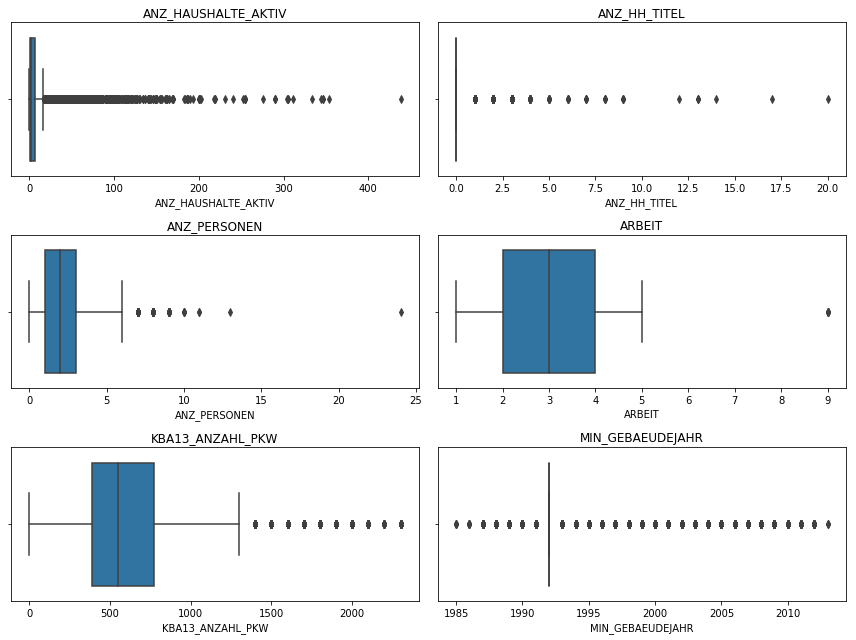

In [47]:
numeric = list(filter(lambda x:x in mailout_train.columns.tolist(),numeric_features))
nr_cols = 2
nr_rows = len(numeric)//nr_cols
li_cat_feats = numeric
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6,nr_rows*3))
for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], data=mailout_train, ax = axs[r][c]).set_title(li_cat_feats[i])
plt.tight_layout()
plt.show()

#### Categorical

In [49]:
columns_OHE=data_types[data_types.Type=='OHE']['Attribute'].tolist()+['GENERATION_DECADE',
                                                                      'Type', 'MOVEMENT','Wealth',
                                                                      'LifeStage']

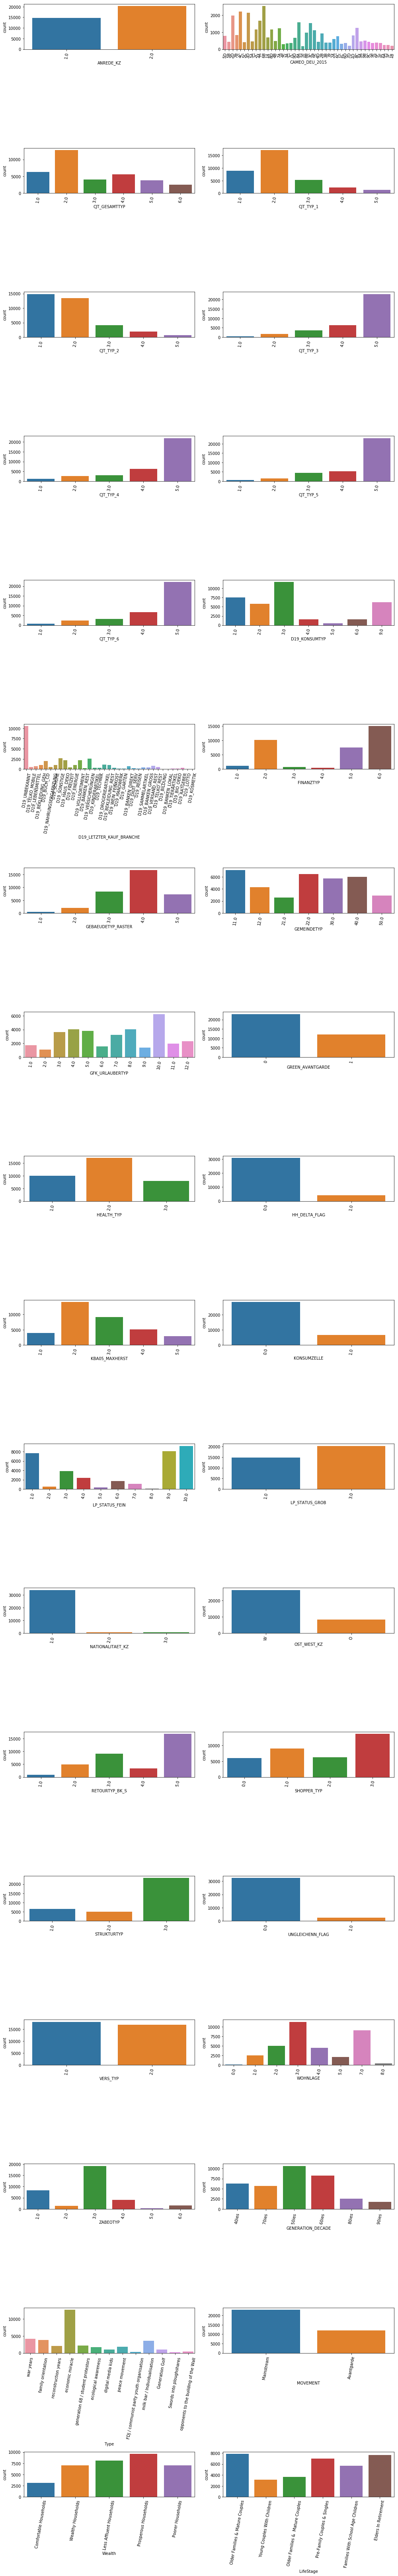

In [63]:
categorical_features = list(filter(lambda x:x in mailout_train.columns.tolist(),columns_OHE))
nr_cols = 2
nr_rows = len(categorical_features)//nr_cols
li_cat_feats = categorical_features
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*7,nr_rows*5))
for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.countplot(x=li_cat_feats[i], data=mailout_train, ax = axs[r][c])
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

### ID

In [87]:
mailout_train.set_index('LNR',inplace=True)

In [54]:
mailout_train.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_BUCH_CD,D19_GESAMT_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_LETZTER_KAUF_BRANCHE,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG2,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,GENERATION_DECADE,Type,MOVEMENT,Wealth,LifeS

In [57]:
mailout_train.shape

(35000, 284)

# Part 2: Supervised Learning Model

We have found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model.

Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [160]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,recall_score,precision_score,f1_score,confusion_matrix,accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [207]:
from utils import plot_confusion_matrix

## Feature Selection

In [291]:
mailout_train.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_BUCH_CD,D19_GESAMT_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_LETZTER_KAUF_BRANCHE,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG2,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,GENERATION_DECADE,Type,MOVEMENT,Wealth,LifeS

In [292]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

### Boruta

In [295]:
from boruta import BorutaPy

In [293]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

In [296]:
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

In [299]:
X_boruta = X.copy()

In [301]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [302]:
columns_label = X_boruta.select_dtypes('O').columns
columns_label

Index(['CAMEO_DEU_2015',
       'D19_LETZTER_KAUF_BRANCHE',
       'OST_WEST_KZ',
       'GENERATION_DECADE',
       'Type',
       'MOVEMENT',
       'Wealth',
       'LifeStage'],
      dtype='object')

In [303]:
X_boruta[columns_label] = label_encoder.fit_transform(X_boruta[columns_label])

ValueError: bad input shape (35000, 8)

In [297]:
# find all relevant features - 5 features should be selected
feat_selector.fit(X_boruta, y)

ValueError: could not convert string to float: '5D'

In [ ]:
# check selected features - first 5 features are selected
feat_selector.support_

In [ ]:
# check ranking of features
feat_selector.ranking_

In [ ]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

## DataSet - Split

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [198]:
y_train.sum()

335

In [199]:
y_test.sum()

100

## Modeling

In [200]:
import datetime
import time

### LogisticRegression

In [201]:
# preprocessing pipelines for both numeric and categorical data.
numeric_features = list(filter(lambda x:x in mailout_train.columns.tolist(),numeric_features))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = categorical_features

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='error',drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [202]:
# Full prediction pipeline. Model : LogisticRegression
clf_pipe = make_pipeline_imb(steps=[('preprocessor', preprocessor),
                                    ('RandomUnderSampler',RandomUnderSampler(sampling_strategy=0.2,random_state=42)),
                                    ('SMOTE', SMOTE(random_state=42)),
                                    ('model', LogisticRegression(class_weight={0:1,1:2}))])

In [203]:
LR_param = {'model__penalty': ['l1','l2'],
            'model__C': [0.0001,0.001,0.1,1,10,100]}

In [204]:
clf = GridSearchCV(clf_pipe,param_grid=LR_param,scoring = 'roc_auc',cv=3,verbose=1,n_jobs=4)

In [205]:
clf.fit(X_train,y_train);

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   27.1s finished


In [206]:
print(f'Best Params   :{clf.best_params_}')
y_pred=clf.predict(X_test)
print(f'ROC AUC       :{roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])}')
print(f'Precision     :{precision_score(y_test, y_pred)}')
print(f'Recall        :{recall_score(y_test, y_pred)}')
print(f'F1            :{f1_score(y_test, y_pred)}')

Best Params   :{'model__C': 0.1, 'model__penalty': 'l2'}
ROC AUC       :0.6144867052023122
Precision     :0.014891416752843847
Recall        :0.72
F1            :0.029179331306990883


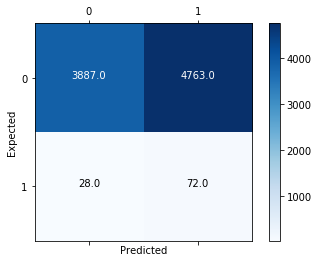

In [208]:
plot_confusion_matrix(y_test, y_pred)

### RandomForestClassifier

In [209]:
# preprocessing pipelines for both numeric and categorical data.
numeric_features = list(filter(lambda x:x in mailout_train.columns.tolist(),numeric_features))

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      #('scaler', StandardScaler())
                                     ])

categorical_features = categorical_features

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='error',drop='first'))
                                         ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [221]:
# Full prediction pipeline. Model : RandomForest
clf_pipe = make_pipeline_imb(steps=[('preprocessor', preprocessor),
                                    #('RandomUnderSampler',RandomUnderSampler(sampling_strategy=0.2,random_state=42)),
                                    #('SMOTE', SMOTE(random_state=42)),
                                    ('model', RandomForestClassifier(class_weight='balanced'))])

In [222]:
RFC_param = {'model__n_estimators': list(range(50,1000,100)),
             'model__max_depth' : list(range(3,20,2))+[None],
             'model__min_samples_leaf' : [1,2,4],
             'model__min_samples_split': [2,5,10],
             'model__max_features':['auto', 'sqrt']}

In [230]:
clf = RandomizedSearchCV(clf_pipe,param_distributions=RFC_param,scoring = 'roc_auc',cv=3,verbose=10,n_jobs=4,n_iter=100)

In [231]:
clf.fit(X_train,y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 11.4min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 17.7min finished


In [232]:
print(f'Best Params   :{clf.best_params_}')
y_pred=clf.predict(X_test)
print(f'ROC AUC       :{roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])}')
print(f'Precision     :{precision_score(y_test, y_pred)}')
print(f'Recall        :{recall_score(y_test, y_pred)}')
print(f'F1            :{f1_score(y_test, y_pred)}')

Best Params   :{'model__n_estimators': 450, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'auto', 'model__max_depth': 7}
ROC AUC       :0.6209630057803468
Precision     :0.021823850350740453
Recall        :0.28
F1            :0.04049168474331164


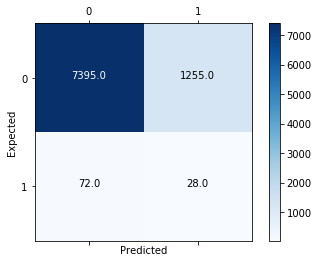

In [233]:
plot_confusion_matrix(y_test, y_pred)

#### Probability Calibration

In [254]:
from sklearn.calibration import CalibratedClassifierCV

In [256]:
best_RandomForest = RandomForestClassifier(class_weight='balanced',n_estimators=450,min_samples_split=2,
                                          min_samples_leaf=1,max_features='auto')

In [262]:
clf_calibration = make_pipeline_imb(steps=[('preprocessor', preprocessor),
                                           ('CalibratedClassifierCV', CalibratedClassifierCV(best_RandomForest,cv=3,method='isotonic'))])

In [263]:
clf_calibration.fit(X_train,y_train);

In [264]:
y_pred=clf_calibration.predict(X_test)
print(f'ROC AUC       :{roc_auc_score(y_test,clf_calibration.predict_proba(X_test)[:,1])}')
print(f'Precision     :{precision_score(y_test, y_pred)}')
print(f'Recall        :{recall_score(y_test, y_pred)}')
print(f'F1            :{f1_score(y_test, y_pred)}')

ROC AUC       :0.5903589595375722
Precision     :0.0
Recall        :0.0
F1            :0.0


### XGBoost

In [265]:
# preprocessing pipelines for both numeric and categorical data.
numeric_features = list(filter(lambda x:x in mailout_train.columns.tolist(),numeric_features))

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      #('scaler', StandardScaler())
                                     ])

categorical_features = categorical_features

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='error',drop='first'))
                                         ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [272]:
#scale_pos_weight=MajorityClass/MinorityClass
pos_weight = int((len(y_train)-y_train.sum())/y_train.sum())

In [273]:
# Full prediction pipeline. Model : XGBoost
clf_pipe = make_pipeline_imb(steps=[('preprocessor', preprocessor),
                                    #('SMOTE', SMOTE(random_state=42)),
                                    ('model', XGBClassifier(scale_pos_weight=pos_weight))])

In [280]:
XGBoost_param = {'model__n_estimators': [50,100,150,200,250,500,700,1000],
                 'model__max_depth':    list(range(5,10,1)),}

In [287]:
clf = GridSearchCV(clf_pipe,param_grid=XGBoost_param,scoring = 'roc_auc',cv=3,verbose=10,n_jobs=4)

In [288]:
clf.fit(X_train,y_train);

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   36.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  8.0min finished


In [289]:
print(f'Best Params   :{clf.best_params_}')
y_pred=clf.predict(X_test)
print(f'ROC AUC       :{roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])}')
print(f'Precision     :{precision_score(y_test, y_pred)}')
print(f'Recall        :{recall_score(y_test, y_pred)}')
print(f'F1            :{f1_score(y_test, y_pred)}')

Best Params   :{'model__max_depth': 8, 'model__n_estimators': 50}
ROC AUC       :0.5960358381502889
Precision     :0.01693480101608806
Recall        :0.2
F1            :0.0312256049960968


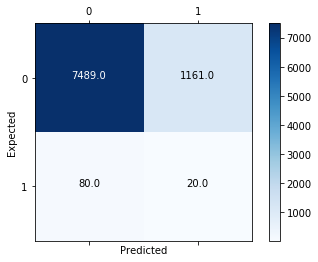

In [290]:
plot_confusion_matrix(y_test, y_pred)

### LGBM

### CATBoost

In [187]:
models_param = [LR_param,
                RFC_param,
                XGBoost_param]


classifiers=['Logistic Regression',
             'RandomForestClassifier',
             'XGBoost']

models=[LogisticRegression(),
        RandomForestClassifier(),
        XGBClassifier()]

In [188]:
# Ciclo iterativo para probar varios modelos
Data_results=pd.DataFrame()
scores = {}

for Name,model,params in zip(classifiers,models,models_param):
    clf_pipe =  make_pipeline_imb([('MinMaxScaler', MinMaxScaler()),
                                   #('PCA'  ,PCA(n_components=top_n)),
                                   #('SMOTE', SMOTE(random_state=42)),
                                   ('model', model)])
    
    print(f'{Name} Start Training at :{datetime.datetime.now()} ')
    clf = RandomizedSearchCV(clf_pipe,param_distributions=params,scoring = 'roc_auc',cv=3,verbose=0,n_jobs=4)
    tic = time.time()
    clf.fit(X_train,y_train)
    toc = time.time()
    print('Time Training :{:.2f} minutes '.format((toc-tic)/60))
    print(f'Best Params   :{clf.best_params_}')
    y_pred=clf.predict(X_test)
    scores['Model Name'] = Name
    scores['ROC AUC']=roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])
    scores['Precision']=precision_score(y_test, y_pred)
    scores['Recall']=recall_score(y_test, y_pred)
    scores['F1']=f1_score(y_test, y_pred)
    print(f'ROC AUC       :{scores["ROC AUC"]}')
    print(f'Precision     :{scores["Precision"]}')
    print(f'Recall        :{scores["Recall"]}')
    print(f'F1            :{scores["F1"]}')
    print('\n')
    D=pd.DataFrame(scores,index=[0])
    Data_results=pd.concat([Data_results, D])

Logistic Regression Start Training at :2019-12-09 12:26:49.482005 
Time Training :0.49 minutes 
Best Params   :{'model__penalty': 'l2', 'model__C': 1}
ROC AUC       :0.6369051864287139
Precision     :0.02397901835893593
Recall        :0.37209302325581395
F1            :0.04505455825413586


RandomForestClassifier Start Training at :2019-12-09 12:27:18.894546 
Time Training :3.16 minutes 
Best Params   :{'model__n_estimators': 150}
ROC AUC       :0.6385796068620835
Precision     :0.018796992481203006
Recall        :0.05813953488372093
F1            :0.02840909090909091


XGBoost Start Training at :2019-12-09 12:30:29.386018 
Time Training :15.23 minutes 
Best Params   :{'model__n_estimators': 100, 'model__max_depth': 5}
ROC AUC       :0.6854533210443446
Precision     :0.02702702702702703
Recall        :0.046511627906976744
F1            :0.03418803418803419




## Feature Importance

In [234]:
features = clf.best_estimator_.named_steps["model"].feature_importances_

In [235]:
nombres=X_train.columns

In [ ]:
df_importance = pd.DataFrame({'nombres':nombres,'features':features})
#df_importance.set_index('nombres', inplace=True)
df_importance.sort_values(['features'],ascending=False).head(25)

## Save Model

In [192]:
# save the model to disk
import pickle

In [193]:
filename = 'best_classifier.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
filename = 'best_classifier.sav'
pickle.dump(clf, open(filename, 'wb'))

# Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [237]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [238]:
mailout_test = replace_NaN_data(mailout_test)
mailout_test = mix_features(mailout_test)

In [239]:
# Social_Status 1,2: low-income earners | 3,4,5: average earners | 6,7: independants | 8,9: houseowners | 10: top earners 
mailout_test.replace({'LP_STATUS_GROB' :  { 2 : 1,
                                      4 : 3,
                                      5 : 3,
                                      7 : 6,
                                      9 : 8,}}, inplace =True)

In [240]:
mailout_test.set_index('LNR',inplace=True)

In [241]:
#Default value  is  0
mailout_test['GEBAEUDETYP_5'] = 0
mailout_test['GEBAEUDETYP_5'] = mailout_test['GEBAEUDETYP_5'].astype('uint8')

In [246]:
y_prob=clf.predict_proba(mailout_test[X.columns])[:,1]

In [247]:
mailout_test['RESPONSE'] = y_prob

In [248]:
mailout_test.reset_index()[['LNR','RESPONSE']].to_csv('data/submission_2.csv',index=False)

![sumbit](img/kaggle.PNG)

not so good... still a lot to look for and Try , but I am in rush ! 

TO DO !

# Considearitons

There are a lot of things I still one to try to improve the project. 

As we can see maybe this wanst the ideal way to clean the data, there are fuetures that now I think I will preprocessed in a different way. Maybe avoiding filling missing values with the mean or mode and try to fill just with the -1.. This could ease the segmentation. 

For the Supervised model I think there are techniques that could help in the feature selection like an ANOVA-TEST or maybe using the feature importance of an ensemble tree to select those. Due to time, those ideas are going to be performed later. 

The final model is way below the expected. But I will try to push that score as far as I can. 

# References

1. [Average Advertisin Costs](https://www.lyfemarketing.com/blog/average-advertising-costs/)
2. [Silhoutte Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
3. [Elbow Method Heuristic](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml)
4. [ROC Curve AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
5. [K-MEANS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)